<a href="https://colab.research.google.com/github/Joyatulya/colab_notebooks/blob/main/CXR_SIMCLR_Pretrainied.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

In [ ]:
# !sudo apt install -qq cadaver
# username BIMCV-PadChest-FULL
# !cadaver https://b2drop.bsc.es/public.php/webdav/

#Plan

## How to approach this??

I want to do a classification problem where my model is able to understand and make diagnosis on the basis of the data that it sees in the cxr

Possible problems or hurdles?
- I had that problem of generalisation in the previous attempt at this, the model did really well on the cxr that is saw and did poorly on everything else.

  How can this be mitigated?? 
  - for starters I could make a labeled dataset from the ambala put dont really know that it will be worht the effort.
  - I could get another random dataset from somewhere else which is already labeled and use that as the test dataset. What I think is that the model learns the different really small nuances inside of the pics which are common to the same localty and i need to be able to mitigate that.

- Another thing is that I want to learn more about the CLIP paradigm of models as from the outside they seem really promising and my mind is being drawn there but i know that I do that quite a lot and that mihgt not be the best thing right now.

## The more important problem

I dont have setup how i will put in the labels from all these datasets and what is the best way to do so and I dont fucking know how to approach that.

- Should I stick to my previous approach and agglomerate these different but similar labels together ot should I go for the new CLIP method.
- Even if go for any of the above methods, my datasets are varied and how will I join them, ie one has reports and the other doesnt have reporsts and the one that has reports have them in spanish.

## Some ideas
1. I can use the simclrv2 to its completion and use that for the classification problema and then distill their knowledge into the smaller models where the classification problem will have a binary classification task and we will construct different models for all the different diseases like other people are doing.

  One more thing that came ot my mind is that I can make  a model with freature representation and then use different classifier heads for different diseases  just like an adaptoer on top of the main backbone which will be really helpful.

  There is one pitfall in this idea as it assumes that the backbone has learned accurate feature representations and that is not quite necessary, Moreover I want to think that should I only train the classifier head or should I tune the base model wiht it also. SHould read more about it in the papers.


For now, lets read the paper that sat us on this path, the cxr semi-supervised paper and try to read a few more things from it and then get on with it. CLIP might be the key.

#Pretraining Prep

##Setting up Enviornment

In [ ]:
!git clone -q  https://github.com/Joyatulya/utils.git
!pip -qq install transformers pytorch-lightning wandb torchtyping
# !pip -qq install -U rich
# !pip install vissl

fatal: destination path 'utils' already exists and is not an empty directory.


In [ ]:
from utils import enviornmet_setup
enviornmet_setup.config_files()

Copying Kaggle/wandb/git


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar, LearningRateMonitor
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
from torch import optim
import torchvision.transforms as T
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import wandb  
from glob import glob
from torchvision import io
import h5py
import shutil
import pathlib
from pytorch_lightning.loggers import WandbLogger
import cv2
from tqdm.auto import tqdm
from torchvision.io.image import ImageReadMode

from sklearn.model_selection import train_test_split

In [ ]:
wandb.login()
pl.seed_everything(1996)

wandb: Currently logged in as: joy_atulya. Use `wandb login --relogin` to force relogin
Global seed set to 1996


1996

In [ ]:
CLINICAL_LABELS = ['PatientID', "PatientBirth",'PatientSex_DICOM', 'ViewPosition_DICOM','Pediatric','ReportID','Report','MethodLabel','Labels','Localizations','LabelsLocalizationsBySentence','labelCUIS', 'LocalizationsCUIS']
HOME_DIR = pathlib.Path().cwd() / 'drive' / 'MyDrive' / 'adv_cxr'

##Data Preparation

In [ ]:
pad_df = pd.read_csv( HOME_DIR / 'padchest' / 'padchest.csv')
nih_df = pd.read_csv( HOME_DIR / 'nih' / 'nih.csv')
vinbig_df = pd.read_csv( HOME_DIR / 'vinbig' / 'vinbig.csv')
tb_df = pd.read_csv( HOME_DIR / 'tb' / 'tb.csv')
combined_df = pd.read_csv(HOME_DIR / 'combined_dataset.csv')
assert len(pad_df) + len(nih_df) + len(vinbig_df) + len(tb_df) == len(combined_df), 'Length of all dataframes dont add up'
# combined_df.rename({'max' : 'max_value'}, axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### BIMCV df

In [ ]:
labels = pad_df.Labels.values
arrayer = np.vectorize(lambda x : ast.literal_eval(x), otypes = ['str'])
# arrayer(labels)
labels
# pad_df.Labels.isna().

In [ ]:
# items_in_h5 = []
# # for key, val in padchest_ds.imgs.items():
#   # items_in_h5.append((key, len(val)))
# for i in range(51):
#   print(padchest_ds.img_names[str(i)], padchest_ds.imgs[str(i)])
# padchest_ds.img_names, padchest_ds.imgs

In [ ]:
# for file_num in range(51):
#   if not pad_df[pad_df.file == file_num].shape == pad_df[pad_df.ImageDir == file_num].shape:
#     print(pad_df[pad_df.ImageDir == file_num].shape)
#     print(pad_df[pad_df.file == file_num].shape)
#     print(file_num)



In [ ]:
# items_in_text_file = []
# for num , f in enumerate((HOME_DIR / 'file_check').glob('*.txt')):
#   with open(f,'r') as file:
#     x = file.readlines()
#     items_in_text_file.append((num, x[-1]))

In [ ]:
# np.array((items_in_text_file, items_in_h5, pad_df.ImageDir.value_counts(sort = False)))

In [ ]:
# from collections import Counter
# all_unique_labels = raw_df.Labels.values
# # '|'.join(all_unique_labels.flatten())
# all_labels = []
# for label in all_unique_labels.flatten():
#   try:
#     label = label.replace('[','')
#     label = label.replace(']','')
#     label = label.replace("'","")
#     label = label.split(',')
#     for word in label:
#       word = word.lstrip()
#       all_labels.append(word)
#     # break
#   except:
#     all_labels.append('ERROR')
# unique_vals = Counter(all_labels)
# unique_vals.most_common()

In [ ]:
def write_to_file(data):
  with open('log_padchest.txt', 'a') as f:
    f.write(data + '\n')

In [ ]:
from typing import Optional
from torchtyping import TensorType
class BaseDataset(data.Dataset):
  """
  Maybe can also add a small buffer instead of a single file which can be used.
  """
  def __init__(self,df, base_dir):
    """
    df : Pandas df which have all the data for our dataset
    base_dir: dir in which we have .h5 files of the data
    """
    super().__init__()
    self.df = df
    self.file = df.file.values
    self.file_index = df.file_index.values
    self.base_dir = base_dir
    self.h5_files = list(base_dir.glob('*.h5'))
    self.imgs, self.img_names = self._load_h5_files()
    assert len(self.imgs) == len(self.img_names), f"Unequal arrays inside of h5 file"

  def __len__(self):
    # You should check here if this is the reason of the index error
    return len(self.df)

  def _load_h5_files(self):
    """
    Loads the generator of images and returns a dict
    """ 
    imgs = {}
    names = {}
    for file in self.h5_files:
      data = h5py.File(file,)
      _imgs = data['img']
      _names = data['name']
      name = file.name.split('.')[0]
      imgs.update({name : _imgs})
      names.update({name : _names})
    return imgs, names
    
## PADCHEST Dataset ##
class PadchestDataset(BaseDataset):
  def __init__(self, df, base_dir):
    super().__init__(df, base_dir)
    self.imageid = df.ImageID.values
    
  def __getitem__(self, idx):
    file_name = str(self.file[idx])
    name_h5 = self.img_names[file_name][self.file_index[idx]].decode()
    name_df = self.imageid[idx]

    try:
      img = self.imgs[file_name][self.file_index[idx]]
    except IndexError as e:
      print(file_name)
      print(name_h5, name_df)
      write_to_file(f"{file_name} = {name_h5} - {name_df}")
      # raise e
      pass

    try:
      assert name_h5 == name_df, f"{name_h5} not equal to {name_df}, in file number {file_name}"
    except AssertionError as e:
      write_to_file(f"{file_name} = {name_h5} - {name_df}")
      pass

    return torch.tensor(img, dtype = torch.float)


In [ ]:
)
total_files = 0
all_files_df = pd.DataFrame(columns=['image_name', 'file_name', 'index_in_file', 'max'])
# all_files = list(HOME_DIR.glob('*/*.h5'))
decoder = np.vectorize(lambda x : x.decode())
for file_num, file_name in tqdm(enumerate(all_files), total = len(all_files)):
  with h5py.File(file_name,'r') as file:
    imgs = file['img']
    names = file['name']
    names =  decoder(names)
    df = pd.DataFrame({
        'image_name' : np.array(names)
    })
    imgs = np.array(imgs)
    df['max'] = np.max(np.max(imgs, 2),-1).flatten()
  df['file_name'] = file_name
  df['index_in_file'] = df.index
  all_files_df = pd.concat((all_files_df, df), ignore_index = True)
  # break
  # total_files += names.shape[0]
# df['file_nums'] = df.index
all_files_df
  # print(imgs[0].max())
#   # print(file, imgs.shape, names.shape)

# fif = h5py.File(all_files[])
# imgs = fif['img']
# imgs[-1][0].max()
# plt.imshow(h5py.File(all_files[50])['img'][0][0])


In [ ]:
# all_files_df['h5_name'] = all_files_df.file_name
# all_files_df['h5_name'] = all_files_df['h5_name'].apply(lambda x : x.name)
# all_files_df.to_csv(HOME_DIR / 'combined_dataset.csv')

In [ ]:
all_files_df = pd.read_csv(HOME_DIR / 'combined_dataset.csv')
class CombinedDataset(Dataset):

  def __init__(self, df):
    super().__init__()
    self.df = df
    self.h5_names = df.h5_name.values
    self.index_in_file = df.index_in_file.values
    self.max_sizes = df['max'].values
    self.h5_files = HOME_DIR.glob('*/*.h5')
    self.imgs, self.img_names = self._load_h5_files()
    self.transform = T.Compose([
          # T.RandomPosterize(3, .2),
          # T.RandomRotation(40, fill = 0),
          T.GaussianBlur(7),
          # T.RandomAutocontrast(0.5),
          T.RandomResizedCrop(284, (.35,1)),
          # T.RandomPerspective(.1),
          # T.RandomEqualize(0.2),
          T.ConvertImageDtype(torch.float),
        T.Normalize(116.549, 72.247)
      ])
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img = self.get_image(idx)
    if self.max_sizes[idx] > 300:
      img = (img * 255) / 65536
    img = torch.tensor(img, dtype = torch.uint8)
    img_1 = self.transform(img)
    img_2 = self.transform(img)
    return img_1, img_2

  def _load_h5_files(self):
    """
    Loads the generator of images and returns a dict
    """ 
    imgs = {}
    names = {}
    for file in self.h5_files:
      data = h5py.File(file,)
      _imgs = data['img']
      _names = data['name']
      name = file.name
      imgs.update({name : _imgs})
      names.update({name : _names})
    return imgs, names

  def get_image(self, idx):
    file_name = self.h5_names[idx]
    index_in_file = self.index_in_file[idx]
    return self.imgs[file_name][index_in_file]
combined_ds = CombinedDataset(all_files_df)
combined_dl = DataLoader(combined_ds, 1024, num_workers = 8)

In [ ]:
TOTAL_FILES = 288781

In [ ]:
## NIHDataset ##seuj;k
class NIHDataset(BaseDataset):
  def __init__(self, df, base_dir):
    super().__init__(df, base_dir)
    self.imageid = df.image_id.values
    self.transform = T.Compose([
        T.ToTensor(),
        # T.Normalize(119.104, 68.831)
    ])
    
  def __getitem__(self, idx):
    file_name = str(self.file[idx])
    img = self.imgs[file_name][self.file_index[idx]]
    img = self.transform(img)
    img= img.moveaxis(1,0).transpose(1,2)
    img = torch.cat((img,img,img), 0)
    return img

vinbig_ds = NIHDataset(vinbig_df, HOME_DIR / 'vinbig')
vinbig_dl = DataLoader(vinbig_ds, 1024)
imgs = next(iter(vinbig_dl))
plt.imshow(imgs[0,0,:])

In [ ]:
class AmbalaDataset(Dataset):
  def __init__(self, base_dir):
    self.base_dir = base_dir
    self.img_list = list(base_dir.glob('*.jpeg'))
    self.transform = T.Compose([
        T.Resize((284,284)),
        T.Normalize(199.104, 69.8)
    ])
  def __len__(self):
    return len(self.img_list)
  
  def __getitem__(self, idx):
    img = io.read_image(str(self.img_list[idx]), mode = ImageReadMode.GRAY).float()
    img = self.transform(img)
    return img

ambala_ds = AmbalaDataset(pathlib.Path('./drive/MyDrive/tb_ambala_cxr'))
ambala_dl = DataLoader(ambala_ds, 32)
next(iter(ambala_dl)).shape

In [ ]:
mean = []
std = []
for img in tqdm(combined_dl, total = len(combined_dl)):
  mean.append(img.mean())
  std.append(img.std())
  # break

In [ ]:
np.mean(mean), np.mean(std)

##NIH

In [ ]:
PATHOLOGY_LIST = ['Cardiomegaly','Emphysema','Effusion',
                  'Pneumothorax','Mass','Edema','Consolidation',
                  'Fibrosis',]
                  
def standardise_df(df):
  working_df = df.copy()
  working_df['findings'] = working_df['findings'].str.replace('Infiltration','Consolidation')
  working_df['findings'] = working_df['findings'].str.replace('Pneumonia','Consolidation')
  working_df['findings'] = working_df['findings'].str.replace('Atelectasis','Consolidation')
  working_df['findings'] = working_df['findings'].str.replace('Nodule/Mass','Mass')
  working_df['findings'] = working_df['findings'].str.replace('Nodule','Mass')
  working_df['findings'] = working_df['findings'].str.replace('Lung Opacity','Mass')
  working_df['findings'] = working_df['findings'].str.replace('Pulmonary fibrosis','Fibrosis')
  working_df['findings'] = working_df['findings'].str.replace('ILD','Fibrosis')
  working_df['findings'] = working_df['findings'].str.replace('Pleural effusion', 'Effusion')
  
  return working_df

In [ ]:
std_nih_df = standardise_df(nih_df)
std_nih_df['Effusion'] = std_nih_df.findings.str.contains('Effusion').astype('float')
std_nih_df = pd.merge(std_nih_df, combined_df, on = 'image_id')

#Training

In [ ]:
from torchvision.transforms.transforms import ToTensor
class ClassificationDataset(Dataset):

  def __init__(self, df, return_id = False):
    '''
    return_id returns the id of images in the geT item method
    '''
    super().__init__()
    self.df = df
    self.image_ids = df.image_id.values
    # For retrieving files
    self.h5_names = df.h5_name.values
    self.index_in_file = df.index_in_file.values
    self.max_sizes = df['max'].values
    self.h5_files = HOME_DIR.glob('*/*.h5')
    self.imgs, self.img_names = self._load_h5_files()
    self.transform = T.Compose([
      T.ToTensor(),
        T.Normalize(116.549, 72.247)
      ])
    self.labels = self.df.Effusion.values
    self.return_id = return_id
    
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img = self.get_image(idx)
    img = self.transform(img)
    img = img.moveaxis(1,0)
    img = img.transpose(1,2)
    label = self.labels[idx]
    if self.return_id: return self.image_ids[idx], img, label
    return img, label

  def _load_h5_files(self):
    """
    Loads the generator of images and returns a dict
    """ 
    imgs = {}
    names = {}
    for file in self.h5_files:
      data = h5py.File(file)
      _imgs = data['img']
      _names = data['name']
      name = file.name
      imgs.update({name : _imgs})
      names.update({name : _names})
    return imgs, names

  def get_image(self, idx):
    file_name = self.h5_names[idx]
    index_in_file = self.index_in_file[idx]
    return self.imgs[file_name][index_in_file]



In [ ]:
from utils.architecture import simclr
simclr = simclr.SimCLR(.07, 1.32, 1e-4, 4000)
simclr = simclr.load_from_checkpoint(HOME_DIR / 'models'/ 'simclr' / 'full' / 'regnet_8_full' / '2jmq032w' / 'checkpoints' / 'simclr-regnet_8_full-epoch=10-val_loss=0.02-val_acc_top5=1.00.ckpt')

In [ ]:
backbone_model = simclr.encoder
backbone_model.requires_grad_(False)
# backbone_model.stem = simclr.encoder.stem
# simclr
backbone_model.fc.requires_grad_(True)

Linear(in_features=1920, out_features=1024, bias=True)

In [ ]:
import torchmetrics as metrics
# from sklearn import metrics
import copy
class Classifier(pl.LightningModule):
  
  def __init__(self,lr, hidden_dim, num_classes,pos_weights, dropout = .1):
    super().__init__()
    self.save_hyperparameters()
    print("\nPositive Weights for the loss are ->", pos_weights, end = '\n')
    self.backbone =copy.deepcopy(backbone_model)
    self.classifier = nn.Sequential(
        nn.ReLU(True),
        nn.Linear(1024, hidden_dim),
        nn.ReLU(True),
        nn.Linear(hidden_dim, num_classes)
    )
    self.avg_prc = metrics.AveragePrecision()
    self.recall = metrics.Recall(num_classes = num_classes)
    self.prec = metrics.Precision(num_classes=num_classes, )

  def forward(self, x):
    return self.classifier(self.backbone(x))

  def training_step(self, batch, batch_idx):
    return self._calculate_loss(batch, mode = 'train')
    
  def validation_step(self, batch, batch_idx):
    self._calculate_loss(batch, mode = 'val')

  def predict_step(self, batch, batch_idx):
    # img_ids, image, labels = batch
    # predictions = self(image)
    # pred_df = pd.DataFrame(
    #     {
    #         'image_id' : img_ids,
    #         'predictions' : predictions.flatten().detach()
    #     }
    # )
    # return pred_df
    imgs, labels = batch
    predictions = self(imgs)  
    return predictions.cpu().numpy().flatten()

  def _calculate_loss(self, batch, mode = 'train'):
    imgs, labels = batch
    preds = self(imgs).view(-1)
    loss = self.loss_fn(preds, labels)
    prc = self.avg_prc(preds, labels.long())
    precision = self.prec(preds, labels.long())
    recall = self.recall(preds, labels.long())
    self.log(f'{mode}_prc', prc, prog_bar = True)
    self.log(f'{mode}_precision', precision, prog_bar = True)
    self.log(f'{mode}_recall', recall, prog_bar = True)
    self.log(f'{mode}_loss', loss, prog_bar = True)
    
    return loss

  def loss_fn(self, preds, labels):
    return nn.BCEWithLogitsLoss(pos_weight = self.hparams.pos_weights)(preds, labels)

  def configure_optimizers(self):
    optimizer = optim.Adam(self.parameters(), lr = self.hparams.lr)
    return optimizer

In [ ]:
model = Classifier.load_from_checkpoint('./drive/MyDrive/adv_cxr/models/classification/Effusion_2048_hidden_1024_samples_no_dropout/3cgj2gki/checkpoints/Effusion_2048_hidden_1024_samples_no_dropout-epoch=3-val_loss=0.63-val_acc_top5=0.00.ckpt')


Positive Weights for the loss are -> tensor([1.], dtype=torch.float64)


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
num_samples = 13317 * 2
path = std_nih_df[std_nih_df.Effusion == 1.].sample(n = num_samples // 2)
non_path = std_nih_df[std_nih_df.Effusion == 0.].sample(n = num_samples // 2)
final_df = pd.concat((path, non_path))
final_df = final_df.sample(frac = 1)

In [ ]:
from pytorch_lightning import callbacks as cb
def train_simclr(model_name,batch_size, max_epochs=500, **kwargs):

    MODEL_NAME = model_name
    CHECKPOINT_PATH = HOME_DIR / 'models' / 'classification'
    NUM_WORKERS = 8

    # logger = pl.loggers.WandbLogger(
    #     project = 'CXR_classification',
    #   name = MODEL_NAME,
    #   group = 'Effusion'    
    # ) 

    model_checkpoint = ModelCheckpoint(
                                 save_weights_only=True,
                                 save_top_k = 3,
                                 filename = f'{MODEL_NAME}' + '-{epoch}-{val_loss:.2f}-{val_prc:.2f}',  
                                  mode='min',
                                   monitor='val_loss'
                                  )
    
    trainer = pl.Trainer(default_root_dir=CHECKPOINT_PATH,
                          accelerator = 'auto',
                          max_epochs=max_epochs,
                          # logger = logger,
                         callbacks=[
                            # model_checkpoint,
                             LearningRateMonitor('epoch'),
                             cb.StochasticWeightAveraging(swa_lrs=1e-2)
                             ],
                        # fast_dev_run = True,
                        #  num_sanity_val_steps=3,
                        #  overfit_batches=10,
                        #  log_every_n_steps = 5,
                        #  val_check_interval = .5,
                         precision = 16,
                         
                        #  auto_scale_batch_size=True
                         )

    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    vals = final_df.Effusion.value_counts().values
    pos_weights = vals[0] / vals[1]
    pos_weights = torch.tensor([pos_weights], device = torch.device('cuda:0'))
    
    train_df, val_df = train_test_split(final_df, test_size = .15)
    train_ds = ClassificationDataset(train_df)
    val_ds = ClassificationDataset(val_df)

    train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True, drop_last = True, pin_memory = True, num_workers = NUM_WORKERS)
    val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False, drop_last = False, pin_memory = True, num_workers = NUM_WORKERS)


    model = Classifier(num_classes = 1, pos_weights = pos_weights,**kwargs)

    try:
      trainer.fit(
        model,
        train_dl,
        val_dl
       
        )
    except KeyboardInterrupt:
      pass
    wandb.finish()
    model = model.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    preds = trainer.predict(model, val_dl) 
    preds = np.array(preds)
    preds = np.hstack(preds)
    val_df['predictions']  = preds
    # pred_df = pd.merge(val)
    return model, val_df

In [ ]:
batch_size = 128
simclr_model, pred_df = train_simclr(
                            model_name = 'Effusion_2048_hidden_full',
                              batch_size=batch_size ,
                            hidden_dim=2048,
                            lr= 5e-4 ,
                            max_epochs = 4
                            )

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Positive Weights for the loss are -> tensor([1.], device='cuda:0', dtype=torch.float64)


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | backbone   | RegNet           | 39.6 M
1 | classifier | Sequential       | 2.1 M 
2 | avg_prc    | AveragePrecision | 0     
3 | recall     | Recall           | 0     
4 | prec       | Precision        | 0     
------------------------------------------------
4.1 M     Trainable params
37.7 M    Non-trainable params
41.7 M    Total params
83.439    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")



Positive Weights for the loss are -> tensor([1.], dtype=torch.float64)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 90it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
def add_metrics(df):
  df['tn'] = (df['bin_pred'] == 0) &  (df['Effusion'] == 0)
  df['fn'] = (df['bin_pred'] == 0) &  (df['Effusion'] == 1)
  df['fp'] = (df['bin_pred'] == 1) &  (df['Effusion'] == 0)
  df['tp'] = (df['bin_pred'] == 1) &  (df['Effusion'] == 1)
  return df

In [ ]:
THRESHOLD = .5
pred_df['bin_pred'] = (pred_df['predictions'] >  THRESHOLD).astype('float')
working_df = pred_df.loc[:, ['image_id', 'position', 'Effusion', 'bin_pred']]
working_df = add_metrics(working_df)
g_position = working_df.groupby('position')
g_sum = g_position.sum()

Effusion    1017.0
bin_pred     760.0
tn          1014.0
fn           452.0
fp           195.0
tp           565.0
dtype: float64

how should we approach this?
# Error analysis

I have dhe Data ahd the model and now i rant to sxtRaxt the error profi
le Out of itrsT 

I should probably make a df inside only with all the Predictions attached iN it
and after that use that to understaNd the error

In [ ]:
model = simclr_model
model.requires_grad_(True)
features_conv = nn.Sequential(
    model.backbone.stem,
    model.backbone.trunk_output
)

torch.Size([1, 1920, 9, 9])
torch.Size([1, 1920])
tensor([[0.5118]], grad_fn=<AddmmBackward0>) tensor([1.], dtype=torch.float64)


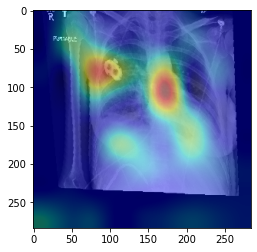

In [ ]:
class Regnet_Grad(nn.Module):
  def __init__(self,):
    super().__init__()
    self.backbone = model.backbone
    self.features_conv = features_conv
    self.cls = model.classifier
    self.pretrained_head = model.backbone.fc
    # self.max_pool = nn.MaxPool2d(kernel_size = 4, stride = 4, padding =0, dilation = 2, ceil_mode = False)
    self.max_pool = model.backbone.avgpool
    self.gradients = None

  def activations_hook(self, grad):
    self.gradients = grad

  def forward(self, x):
    self.zero_grad()
    x = self.features_conv(x)
    # x.requires_grad = True
    print(x.shape)
    h = x.register_hook(self.activations_hook)

    x = self.max_pool(x)
    x = x.flatten(1,-1)
    print(x.shape)
    x = self.pretrained_head(x)
    x = self.cls(x)
    return x

  def get_activations_gradients(self):
    return self.gradients

  def get_activations(self, x):
    return self.features_conv(x)

grad_model = Regnet_Grad()
ds= ClassificationDataset(final_df)
dl = DataLoader(ds, 1, shuffle = True)
imgs, labels = next(iter(dl))
preds=  grad_model(imgs)
# preds += 1.
preds.backward()
from torchvision.transforms.functional import InterpolationMode
ds= ClassificationDataset(final_df)
dl = DataLoader(ds, 1, shuffle = True)
imgs, labels = next(iter(dl))
plt.set_cmap('gray')
gradients = grad_model.get_activations_gradients()
# Somehting odd happened with the registed hook as teh shape here is 1920 x 9 x9 which is same as the features conv
pooled_gradients = torch.mean(gradients, dim = [0,2,3])
activations = grad_model.get_activations(imgs).detach()

pooled_gradients.shape, activations.shape
for i in range(pooled_gradients.shape[0]):
  activations[:,i,:,:] *= pooled_gradients[i]

heatmap =torch.mean(activations, dim = 1).squeeze()
heatmap = F.relu(heatmap)
heatmap /= torch.max(heatmap)
# plt.imshow(heatmap)
# print(heatmap.shape)
heatmap_up = T.Resize((284,284),interpolation = InterpolationMode.BICUBIC)(heatmap[None,:])
plt.imshow(imgs[0,0,:])
plt.imshow(heatmap_up[0], cmap = plt.cm.jet, alpha = 0.4)
print(preds, labels)

In [ ]:
simclr_model

Classifier(
  (backbone): RegNet(
    (stem): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (trunk_output): Sequential(
      (block1): AnyStage(
        (block1-0): ResBottleneckBlock(
          (proj): Conv2dNormActivation(
            (0): Conv2d(32, 80, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (f): BottleneckTransform(
            (a): Conv2dNormActivation(
              (0): Conv2d(32, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (b): Conv2dNormActivation(
              (0): Conv2d(80, 80, kernel_size=(3, 3), s

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
# simclr_model.cpu()
trunk = simclr_model.backbone.trunk_output
target = [
    trunk.get_submodule('block2').get_submodule('block2-2').f.c[0],
    # trunk.get_submodule('block2').get_submodule('block2-1').f.c[0],
    # trunk.get_submodule('block2').get_submodule('block2-3').f.c[0],
    # trunk.get_submodule('block2').get_submodule('block2-4').f.c[0],
    # trunk.get_submodule('block2').get_submodule('block2-5').f.c[0],
    # trunk.get_submodule('block2').get_submodule('block2-6').f.c[0],
    # trunk.get_submodule('block2').get_submodule('block2-7').f.c[0],
    # trunk.get_submodule('block1').get_submodule('block1-1').f.c[0],
    # trunk.get_submodule('block3').get_submodule('block3-3').f.c[0],
]
# target = [model.encoder.trunk_output.block2.get_submodule('block2-2').f.c[0]]

ds = ClassificationDataset(final_df)
dl = DataLoader(ds, 16, shuffle = True)
imgs, labels= next(iter(dl))
imgs = imgs.cuda()
print(imgs.shape)
cam= GradCAM(simclr_model, target, True)
# targets = [ClassifierOutputTarget(labels)]
gray_cam = cam(imgs)
fig, ax = plt.subplots(4,4, figsize= (30,30))

ax = ax.ravel()
for i in range(16):
  ax[i].imshow(imgs[i,0,:], cmap = 'gray')
  ax[i].imshow(gray_cam[i], alpha = .5, cmap = 'jet')

torch.Size([16, 1, 284, 284])


AxisError: ignored

### Implemet a good expandable pipeline for testing purposes which can be used in future projects also.T